Objective
This notebook compares downside tail risk under the Black–Scholes and Merton jump–diffusion models using Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR). While higher moments such as skewness and kurtosis can be unstable, VaR and CVaR provide economically interpretable measures of extreme loss

In [15]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from src.simulation import simulate_merton_paths

In [32]:
S0 = 100.0
r = 0.05
T = 1.0
n_steps = 252
n_paths = 200000

# Same diffusion volatility
sigma = 0.18

# Black–Scholes (no jumps)
params_bs = dict(
    lam=0.0,
    mu_J=0.0,
    sigma_J=0.0
)

# Merton jump–diffusion
params_merton = dict(
    lam=2.5, #more frequent for better statistics
    mu_J=-0.35,
    sigma_J=0.25
)

In [33]:
paths_bs = simulate_merton_paths(
    S0, r, sigma,
    lam=params_bs["lam"],
    mu_J=params_bs["mu_J"],
    sigma_J=params_bs["sigma_J"],
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=123
)

paths_merton = simulate_merton_paths(
    S0, r, sigma,
    lam=params_merton["lam"],
    mu_J=params_merton["mu_J"],
    sigma_J=params_merton["sigma_J"],
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=123
)


In [34]:
def log_returns(paths):
    return np.diff(np.log(paths), axis=1).flatten()

rets_bs = log_returns(paths_bs)
rets_merton = log_returns(paths_merton)

losses_bs = -rets_bs
losses_merton = -rets_merton

In [35]:
def var_cvar(losses, alpha = 0.99):
    var = np.quantile(losses, alpha)
    cvar = losses[losses>=var].mean()
    return var, cvar


In [36]:
alpha = 0.99

var_bs, cvar_bs = var_cvar(losses_bs, alpha)
var_merton, cvar_merton = var_cvar(losses_merton, alpha)

print("99% Daily VaR")
print("Black–Scholes:", var_bs)
print("Merton       :", var_merton)
print()

print("99% Daily CVaR")
print("Black–Scholes:", cvar_bs)
print("Merton       :", cvar_merton)


99% Daily VaR
Black–Scholes: 0.02623388230184443
Merton       : 0.0316021249447982

99% Daily CVaR
Black–Scholes: 0.030070045058186074
Merton       : 0.3570251336982047


Diffusion-only models therefore substantially underestimate tail risk, particularly during rare but severe market dislocations.

Text(0.5, 0, 'Daily loss')

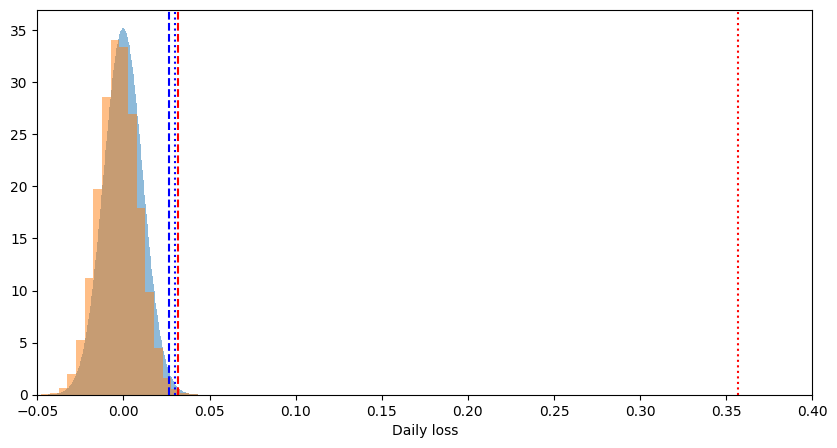

In [41]:
plt.figure(figsize=(10, 5))

plt.hist(losses_bs, bins=500, density=True, alpha=0.5, label="Black–Scholes")
plt.hist(losses_merton, bins=500, density=True, alpha=0.5, label="Merton")

plt.axvline(var_bs, color="blue", linestyle="--", label="BS VaR")
plt.axvline(cvar_bs, color="blue", linestyle=":", label="BS CVaR")

plt.axvline(var_merton, color="red", linestyle="--", label="Merton VaR")
plt.axvline(cvar_merton, color="red", linestyle=":", label="Merton CVaR")
plt.xlim(-0.05,0.40)
plt.xlabel("Daily loss")
